# Livewire segmentation algorithm

In this notebook, we want to reproduce Livewire algorithm and compute the shortest path between two clicks.

We will need an implementation of Dijkstra's shortest path algorithm (dijkstra.py) and an example DICOM slice image.

If you are in a hurry, execute the whole notebook and scroll back to the last line!

# Input
Read a DICOM slice image from file, convert it to a numpy array (http://www.osirix-viewer.com/datasets/). There is a number of freely available DICOM images online.

In [106]:
import skimage

In [107]:
import dicom

In [108]:
df = dicom.read_file('../IM-0001-0011.dcm')

In [109]:
image = skimage.img_as_uint(df.pixel_array)

In [110]:
from skimage import io
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

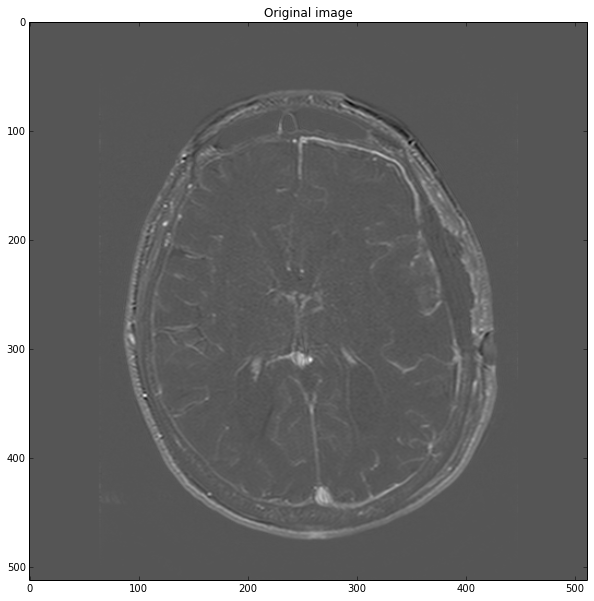

In [111]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title('Original image')

# Reduce image noise

http://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html

In [112]:
from skimage import restoration

In [113]:
denoised_image = restoration.denoise_bilateral(image)

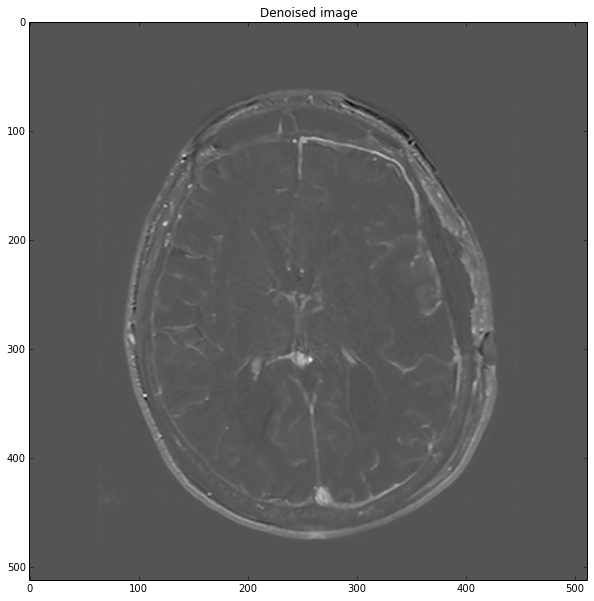

In [114]:
plt.figure(figsize=(10,10))
plt.imshow(denoised_image)
plt.title('Denoised image')

# Compute gradient image 
(http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel)

In [115]:
from skimage import filters

In [130]:
edges = filters.scharr(denoised_image)

In [131]:
plt.figure(figsize=(10,10))
plt.imshow(edges)
plt.title('Gradient image')

# Compare images

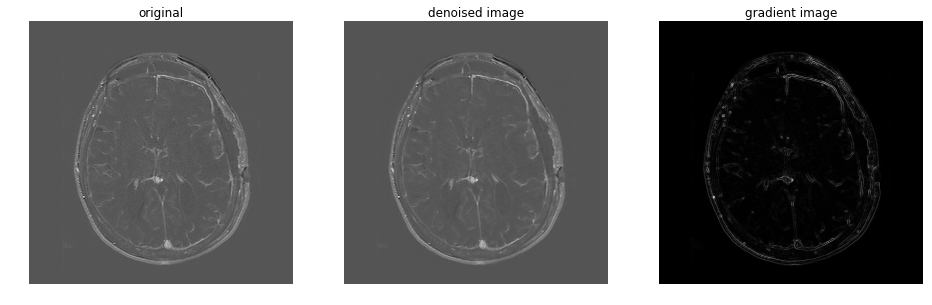

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

plt.gray()

ax[0].imshow(image, cmap=pylab.cm.gray)
ax[0].axis('off')
ax[0].set_title('original')
ax[1].imshow(denoised_image, cmap=pylab.cm.gray)
ax[1].axis('off')
ax[1].set_title('denoised image')
ax[2].imshow(edges, cmap=pylab.cm.gray)
ax[2].axis('off')
ax[2].set_title('gradient image')

# Convert gradient image into a graph
Use the dictionary representation of a graph (https://www.python.org/doc/essays/graphs/)

In [132]:
from math import fabs

G = {}
rows, cols = edges.shape
for col in range(cols):
    for row in range(rows):
        
        neighbors = []
        if row > 0:
            neighbors.append( (row-1, col) )
        
        if row < rows-1:
            neighbors.append( (row+1, col) )
            
        if col > 0:
            neighbors.append( (row, col-1) )
        
        if col < cols-1:
            neighbors.append( (row, col+1) )
        
        dist = {}
        for n in neighbors:
            n[0], n[1]
            dist[n] = fabs(edges[row][col] - edges[n[0], n[1]])
            
        G[(row,col)] = dist

# Compute shortest path
Re-use Dijkstra algorithm (http://code.activestate.com/recipes/119466-dijkstras-algorithm-for-shortest-paths/). The solution from the comment has been taken, since it is much faster than the original code.

In the pop-up window, left-click once to set the starting point for the segmentation. If you enable INTERACTIVE mode, then you will see suggestions as you move you mouse around. Left-click again, to set the next point. You cannot modify the contour once the next point has been set. Pressing ESCAPE on the keyboard closes one contour. After that, you can segment another structure.

In [120]:
import sys
sys.path.append('..')
from dijkstra import shortestPath

In [133]:
%matplotlib 
INTERACTIVE = True
from itertools import cycle
COLORS = cycle('rgbyc')

start_point = None
current_color = COLORS.next()
current_path = None

def button_pressed(event):
    global start_point
    if start_point is None:
        start_point = (int(event.xdata), int(event.ydata))
        
    else:
        end_point = (int(event.xdata), int(event.ydata))
        path = shortestPath(G, start_point, end_point)
        plt.plot(np.array(path)[:,0], np.array(path)[:,1], c=current_color)
        start_point = end_point

def mouse_moved(event):
    if start_point is None:
        return
    
    #print event
    end_point = (int(event.xdata), int(event.ydata))
    #print start_point, end_point
    path = shortestPath(G, start_point, end_point)
    
    global current_path
    if current_path is not None:
        current_path.pop(0).remove()
    current_path = plt.plot(np.array(path)[:,0], np.array(path)[:,1], c=current_color)

def key_pressed(event):
    if event.key == 'escape':
        global start_point, current_color
        start_point = None
        current_color = COLORS.next()

        global current_path
        if current_path is not None:
            current_path.pop(0).remove()
            current_path = None
            plt.draw()

plt.connect('button_release_event', button_pressed)
if INTERACTIVE:
    plt.connect('motion_notify_event', mouse_moved)
plt.connect('key_press_event', key_pressed)

plt.imshow(image)
plt.autoscale(False)
plt.title('Livewire example')
plt.show()

Using matplotlib backend: MacOSX
